In [1]:
data_final = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/suyashlakhani/tweets2")

22/12/07 08:44:38 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


**6. How unique are the messages?**

**6.1 Are they mostly unique? Or usually people are just copy-pasting the same text?**

**6.2 You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity**

In [2]:
import os
import shutil
from itertools import islice
import requests

import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Create spark_session
spark = SparkSession.builder.getOrCreate()
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '32g'), ('spark.app.name', 'Spark Updated Conf'), 
                                        ('spark.executor.cores', '32'), ('spark.cores.max', '32'), ('spark.driver.memory','32g')])
spark.sparkContext.getConf().getAll()

from IPython.display import clear_output
clear_output(wait = False)

spark.version

import time
start_time = time.time()


In [3]:
data_final = data_final.withColumn("Organization",
                        F.when(data_final.verified_user == 'false', 'Other') \
                        .when((data_final.user_description.contains('university')) 
                              | (data_final.user_name.contains('university')) 
                              | (data_final.user_name.contains('University'))
                              | (data_final.user_name.contains('School of')), 'University')
                        .when((data_final.user_description.contains('school')) 
                              | (data_final.user_name.contains('school')) 
                              | (data_final.user_name.contains('School')) , 'School')  
                        .when((data_final.user_description.contains('nonprofit organization')), 'nonprofit organization')                             
                        .when((data_final.user_description.contains('gov')) 
                              | (data_final.user_name.contains('gov')) 
                              | (data_final.user_name.contains('Department of')) \
                              | (data_final.user_description.contains('president')) 
                              | (data_final.user_name.contains('president')) \
                              | (data_final.user_description.contains('senat')) 
                              | (data_final.user_name.contains('senat')) \
                              | (data_final.user_description.contains('congress')) 
                              | (data_final.user_name.contains('congress')) \
                              | (data_final.user_description.contains('prime minister')) 
                              | (data_final.user_name.contains('prime minister')) \
                              | (data_final.user_description.contains('parliament')) 
                              | (data_final.user_name.contains('parliament')) \
                              | (data_final.user_description.contains('vp')) 
                              | (data_final.user_name.contains('vp')) \
                              | (data_final.user_description.contains('white house')) 
                              | (data_final.user_name.contains('white house')) \
                              | (data_final.user_description.contains('mayor')) 
                              | (data_final.user_name.contains('mayor')) \
                              | (data_final.user_description.contains('democr')) 
                              | (data_final.user_name.contains('democr')) \
                              | (data_final.user_description.contains('republic')) 
                              | (data_final.user_name.contains('republic')), 'Government') \
                        .when((data_final.user_description.contains('news')) 
                              | (data_final.user_name.contains('news')) \
                              | (data_final.user_description.contains('News'))
                              | (data_final.user_name.contains('News')) \
                              | (data_final.user_description.contains('daily')) 
                              | (data_final.user_name.contains('daily')) \
                              | (data_final.user_description.contains('times')) 
                              | (data_final.user_name.contains('times')) \
                              | (data_final.user_description.contains('journal')) 
                              | (data_final.user_name.contains('journal')), 'News') \
                        .when(((data_final.user_description.contains('actor')) & (data_final.followers_count > 10000)) \
                              | ((data_final.user_description.contains('singer')) & (data_final.followers_count > 10000)) \
                              | ((data_final.user_description.contains('writer')) & (data_final.followers_count > 10000)) \
                              | ((data_final.user_description.contains('play')) & (data_final.followers_count > 10000)) \
                              | ((data_final.user_description.contains('musician')) & (data_final.followers_count > 10000)) \
                              | ((data_final.user_description.contains('actress')) & (data_final.followers_count > 10000)) \
                              | ((data_final.user_description.contains('golfer')) & (data_final.followers_count > 10000)) \
                              | ((data_final.user_description.contains('author')) & (data_final.followers_count > 10000)), 'Celebrity') \
                        .when(data_final.followers_count >= 5000, 'Influencer'))

In [4]:
data_final = data_final.na.fill(value='Other',subset=["Organization"])

In [5]:
data_final.count()

26921707

In [6]:
data_final.limit(3).toPandas()

,created_at,user,user_id,user_name,user_description,followers_count,quote_count,retweeted_status,retweet_count,favorite_count,text,verified_user,user_location,Organization
0,Wed Aug 24 17:29:41 +0000 2022,"(False, Mon Oct 04 18:02:23 +0000 2021, True, ...",1445086760938127372,Kevster,"Pro Medical Choice, Forest bather, Outdoors en...",147,11,"(None, Wed Aug 24 13:42:50 +0000 2022, None, (...",88,290,"RT @AndrewLawton: ""Western knows its vaccine m...",False,None,Other
1,Wed Aug 24 17:29:42 +0000 2022,"(False, Sun Apr 26 02:15:57 +0000 2009, False,...",35375399,Daniel Lewis,"Visit Our New Ruined Downtown, #maga, #America...",1161,5,"(None, Wed Aug 24 17:15:05 +0000 2022, None, (...",94,334,RT @StephenM: Here’s what we should do re: col...,False,Sarasota Florida,Other
2,Wed Aug 24 17:29:42 +0000 2022,"(False, Wed Oct 13 02:30:05 +0000 2021, True, ...",1448113670802837514,"William Turner, PhD, JD",Check out the recent history of the grossly de...,521,31,"(None, Tue Aug 23 20:14:22 +0000 2022, None, (...",1198,9651,RT @fuckyouiquit: If they cancelled all studen...,False,"Ph.D. US History, JD",Other


In [5]:
keywords = ['children', 'kindergarten', 'testing', 'grade', 'student', 'grades', 'education', 'teachers', 'schools', 'college', 'students','math', 'science', 'primary_school', 'elementary_school', 'high_school', 'pre_school', 
                  'middle_school', 'k12', 'k-12', 'book', 'curriculum', 'learning', 'colleges', 'tuition']

In [6]:
#Here, for useful processing, I am only selecting the tweets that have education related words more than once in thier text. 

@F.udf
def count_filtering(text):
    global keywords
    words = text.split()
    total_count = 0
    for i in keywords:
        occurance_count = words.count(i)
        total_count += occurance_count

    if(total_count >= 2):
        return 1
    else:
        return 0
    

data_final = data_final.withColumn("count_filtered", count_filtering("text"))

In [7]:
data_final2 = data_final.filter("count_filtered == 1")
data_final2.count()

1884157

In [8]:
#Selecting only the originial messages and not retweets
data_final3 = data_final2.filter("retweeted_status is null")

data_final3.count()

463857

**Jaccard Similarity**

In [17]:
def get_tokens(df):
    return df\
        .map( lambda document: re.sub(r'[^a-zA-Z0-9 ]', '', document))\
        .map( lambda document: document.strip().lower())\
        .map( lambda document: re.split(" ", document))\
        .map( lambda word: [x for x in word if len(x) >= 2] )\
        .map( lambda word: [x for x in word if x not in StopWords])\
        .zipWithIndex()

def to_DF(rdd_, col):    
    row = Row(col)
    return rdd_.map(row).zipWithIndex().toDF([col, 'id'])

def token_cleaning(tokens):
    df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
    df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
    return df_tokens


In [18]:
mh = MinHashLSH(inputCol = "features", outputCol = "hashes", numHashTables = 5)
def get_df_hashed(df_vectorize):
    model = mh.fit(df_vectorize)
    df_hashed = mh.fit(df_vectorize).transform(df_vectorize)
    return model, df_hashed

In [19]:
def getJaccardBarChart(df, jaccard_distance,model):

    df_dups_text = model.approxSimilarityJoin(
                        df, df, jaccard_distance
                    ).filter("datasetA.id < datasetB.id").select(
                        col("distCol"),
                        col("datasetA.id").alias("id_A"),
                        col("datasetB.id").alias("id_B"),
                        col("datasetA.text").alias('text_A'),
                        col("datasetB.text").alias('text_B')
                    )

    df_dups_text.cache()
    #df_dups_text.limit(5).toPandas()
    
    records = df.count()
    dups = df_dups_text.select('id_A').distinct().count()
    uniques = records - dups
    
    return df_dups_text, records, dups

In [12]:
df_sim = data_final3.select(['text', 'Organization'])

In [13]:
df_sim.write.format("parquet").mode('overwrite').save('gs://msca-bdp-students-bucket/shared_data/suyashlakhani/tweets6')

In [13]:
inf_profile = data_final3.groupby("Organization").count().orderBy('count',ascending=False).toPandas()

inf_profile

,Organization,count
0,Other,441916
1,News,11578
2,Influencer,7944
3,School,985
4,Government,796
5,University,390
6,Celebrity,246
7,nonprofit organization,2


In [17]:
org_list  = inf_profile["Organization"].tolist()

In [18]:
org_list

['Other',
 'News',
 'Influencer',
 'School',
 'Government',
 'Celebrity',
 'University',
 'nonprofit organization']

In [14]:
df_sample_final = df_sim.sample(0.05,seed=42)

In [15]:
tweets = df_sample_final.rdd.map(lambda x : x['text'])

In [16]:
StopWords = stopwords.words("english")
tweet_tokens = get_tokens(tweets)

In [17]:
df_tweets = to_DF(tweets, 'text')

In [18]:
df_sample_final.count()

23296

In [19]:
#StopWords = stopwords.words("english")
df_tweet_tokens = token_cleaning(tweet_tokens)

In [20]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_tweet_tokens_vectorized = vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [21]:
model, df_hashed= get_df_hashed(df_tweet_tokens_vectorized)

df_hashed_text_joined = df_tweets.join(df_hashed, "id", how = 'left')

df_hashed_text_joined = df_hashed_text_joined.\
                                where(size(df_hashed_text_joined.list_of_words) >= 5)

In [ ]:
import seaborn as sns 
text_dups_list = []
df_dups_text_20, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.2)
text_dups_list.append([records, dups, records - dups, 0.2])

df_dups_text_40, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.4)
text_dups_list.append([records, dups, records - dups, 0.4])

df_dups_text_50, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.5)
text_dups_list.append([records, dups, records - dups, 0.5])

df_dups_text_60, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.6)
text_dups_list.append([records, dups, records - dups, 0.6])

df_dups_text_70, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.7)
text_dups_list.append([records, dups, records - dups, 0.7])

df_duplicates = pd.DataFrame(text_dups_list, columns = ['counts', 'dups', 'unique', 'threshold'])
#plt.tight_layout()
#sns.barplot(y=['unique','dups'],x="threshold",data=df_duplicates,palette="Spectral",title="Tweets Duplication Analysis")
#df_duplicates.plot(x = 'threshold', y = ['unique','dups'], kind = 'bar', title = "Tweets Duplication Analysis")
#plt.show()

22/12/07 01:19:26 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670090078315_0023_01_000059 on host: hub-msca-bdp-dphub-students-suyashlakhani-sw-jkj8.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-07 01:19:26.068]Container killed on request. Exit code is 143
[2022-12-07 01:19:26.068]Container exited with a non-zero exit code 143. 
[2022-12-07 01:19:26.092]Killed by external signal
.
22/12/07 01:19:26 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670090078315_0023_01_000063 on host: hub-msca-bdp-dphub-students-suyashlakhani-sw-jkj8.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-07 01:19:26.092]Container killed on request. Exit code is 143
[2022-12-07 01:19:26.092]Container exited with a non-zero exit code 143. 
[2022-12-07 01:19:26.093]Killed by external signal
.
22/12/07 01:19:26 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoi

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

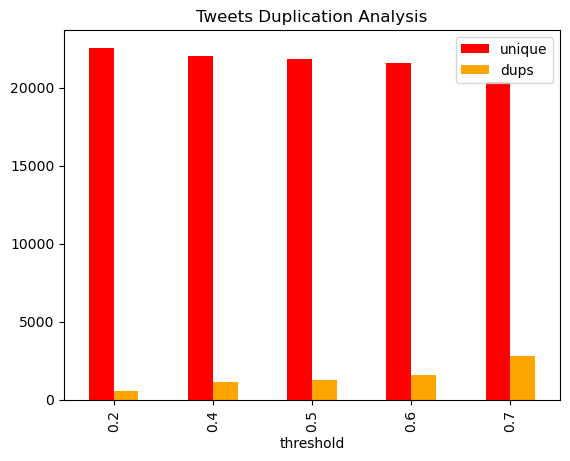

In [32]:
plt.tight_layout()
df_duplicates.plot(x = 'threshold', y = ['unique','dups'], kind = 'bar', title = "Tweets Duplication Analysis",color=["red","orange"])
plt.show()


--> We can see that the messages are almost all unique with a few exceptions. Looks like people are not copy-pasting the same thing. 